In [ ]:
# data numerical processing
import pandas as pd
import numpy as np

# statistical visuallization
import seaborn as sns

# StandardScalar normalizing numeric data and making a mean 0
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale

# split the data to train/test dataset
from sklearn.model_selection import train_test_split

# data visualization and graphical plotting
import matplotlib.pyplot as plt

## Select a dataset for your project – you may use the 10 times rule to just check on the size of your data! The rule is if you have x number of parameters to model you should have at least 10x data records to train. For example, if you want to classify cats and dogs based on 1000 parameters, you will need 10,000 pictures to train the model.

Our study aims to produce a traffic model that can represent the flow of traffic in the ACT. To do so, we utilise the ‘Traffic Link Stats’ dataset provided by Open Data Portal dataACT [1]. In our model, the dataset is supplied via shared Google Drive in which the dataset is saved in CSV format. The chosen dataset consists of 20 variables and 21,691,360 observations in its raw form, and contains performance statistics with geometry of traffic flow recorded at a sequence of 5 minutes between 25-05-2020 to 28-07-2022. During the dataset collection process, a variable ‘Line’ was omitted due to insufficient information. The dataset was sampled to contain only the most recent 1 millions observations for further processes due to limited computational power available. Once the sampling process is completed, the resulting dataset is exported and saved as a CSV file in Google Drive and is available via a link for the purpose of recreating the project.

In [ ]:
# # Import raw dataset from google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # import raw dataset
# Data_Path = '/content/drive/MyDrive/11482_PRLM_Colab/data/Traffic_Links_Stats.csv'
# # collect last 1 million rows and exclude a varialbe 'Link'
# traffic_df = pd.read_csv(Data_Path, skiprows=range(1,21691361-1000000), usecols = [i for i in range(19)])

# # export dataset into a csv file and save to google drive
# traffic_df.to_csv(r'/content/drive/MyDrive/11482_PRLM_Colab/Traffic_Links_Stats_sampled.csv')

# Import the saved dataset
# To recreate this project the dataset is available via link: https://drive.google.com/file/d/1CFC2L_nbL5nLAYFbB6HEuabPFfavsGsG/view?usp=sharing
# or run the code below to directly downlaod the dataset
import json
traffic_df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=9iBg&id=1CFC2L_nbL5nLAYFbB6HEuabPFfavsGsG', converters = {'Trend': json.loads}, index_col=[0])

# Remove unnecessary strings
traffic_df['IntervalStart'] = traffic_df['IntervalStart'].str[:15].str.replace('T',' ')

# Parsing into timestamp format
from datetime import datetime
traffic_df['IntervalStart'] = pd.to_datetime(traffic_df['IntervalStart'])

# first 3 rows
traffic_df.head(3)

,Closed,Congestion,Delay,DestSiteId,Direction,EnoughData,ExcessDelay,Id,IntervalStart,IsFreeway,Length,MinNumberOfLanes,MinTT,Name,OriginSiteId,Score,Speed,TT,Trend
0,False,2,5,79,SWB,False,26,507,2021-09-03 10:05:00,False,616,1,107,Edinburgh Av - Vernon Circle to Parkes Way,10027,0,19,112,"[85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74]"
1,False,0,15,52,N,True,-23,9,2021-09-03 10:05:00,False,889,1,45,Coulter Dr - Belconnen Way to Southern Cross Dr,38,0,53,60,"[77, 72, 70, 69, 61, 54, 51, 49, 48, 49, 56, 69]"
2,False,0,-12,10017,EB,True,-19,467,2021-09-03 10:05:00,False,249,1,13,Lanyon Dr - Monaro Hwy NB to Monaro Hwy SB,231,0,300,1,"[18, 18, 17, 16, 15, 14, 18, 19, 15, 17, 17, 17]"


In [ ]:
# Start and Finish time
traffic_df['IntervalStart'].agg([min, max])

min   2021-09-03 10:05:00
max   2022-07-28 21:01:00
Name: IntervalStart, dtype: datetime64[ns]

In [ ]:
# Initial anaylsys
print(traffic_df.info())

# dataframe dimension
print(traffic_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Closed            1000000 non-null  bool          
 1   Congestion        1000000 non-null  int64         
 2   Delay             1000000 non-null  int64         
 3   DestSiteId        1000000 non-null  int64         
 4   Direction         992584 non-null   object        
 5   EnoughData        1000000 non-null  bool          
 6   ExcessDelay       1000000 non-null  int64         
 7   Id                1000000 non-null  int64         
 8   IntervalStart     1000000 non-null  datetime64[ns]
 9   IsFreeway         1000000 non-null  bool          
 10  Length            1000000 non-null  int64         
 11  MinNumberOfLanes  1000000 non-null  int64         
 12  MinTT             1000000 non-null  int64         
 13  Name              1000000 non-null  object 

Therefore, the resulting dataset contains 19 variables and 1 million observations that are recorded during 390 days between 03-07-2021 to 28-07-2022. Variables in the dataset exist in varying data types. Of the 19 variables, most are numerical variables, followed by categorical, boolean and date/time data types. Some of the variables in the dataset are modified forms of other variables. For example, a variable ‘Congestion’ in the dataset represents a variable ‘ExcessDelay’ converted into a standard deviation. In our study, we explore whether such variables that directly relate to each other are beneficial to our modelling task by analysing the significance of individual variables.

Our model will predict a variable ‘Delay’ against other variables in the dataset. The Delay variable represents the traffic delay at the time of observation recorded in seconds. Utilising the 10 times rule, the chosen dataset has 19 parameters that are recorded one million times which yields a parameter-to-record ratio of 1:52632. Therefore, we expect that the dataset will provide sufficient information to a machine learning model during its training process [2].

## Analyse Data: Use descriptive statistics and visualization to better understand the dataset.

<p>In our study, we aim to identify appropriate machine learning models for the chosen dataset. In doing so, we explore the chosen dataset by applying a series of descriptive statistical analysis and data transformations techniques to convert the dataset into a more suitable format for modelling.</p>

In [ ]:
# Summary target variable
traffic_df.describe()

,Congestion,Delay,DestSiteId,ExcessDelay,Id,Length,MinNumberOfLanes,MinTT,OriginSiteId,Score,Speed,TT
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.188980,12.472306,4172.701722,-5.606939,393.681503,1698.365308,1.119943,90.716085,4177.689648,0.009120,61.693615,103.188391
std,1.020751,23.269376,4864.222067,20.901625,204.473039,1206.726133,0.337957,60.485245,4860.468610,0.173052,24.607083,67.737773
min,0.000000,-338.000000,1.000000,-382.000000,0.000000,75.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000
25%,0.000000,2.000000,72.000000,-13.000000,235.000000,854.000000,1.000000,47.000000,74.000000,0.000000,47.000000,56.000000
50%,0.000000,8.000000,235.000000,-5.000000,423.000000,1387.000000,1.000000,76.000000,236.000000,0.000000,61.000000,88.000000
75%,0.000000,18.000000,10021.000000,2.000000,568.000000,2172.000000,1.000000,115.000000,10021.000000,0.000000,74.000000,132.000000
max,94.000000,919.000000,10087.000000,907.000000,706.000000,7671.000000,3.000000,370.000000,10087.000000,7.000000,300.000000,1033.000000


<p>Plotting a histogram of the ‘Delay’ variable reveals a slightly normal distribution that is skewed to the right. Plotting a box plot reveals numerous outliers. </p>

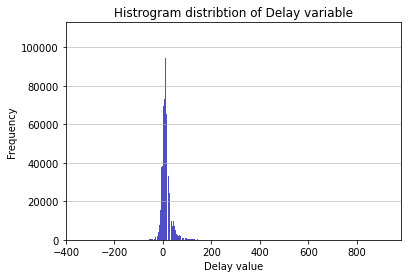

In [ ]:
# Histrogram distribtion of the target variable
n, bins, patches = plt.hist(x=traffic_df['Delay'], bins=500, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Delay value')
plt.ylabel('Frequency')
plt.title('Histrogram distribtion of Delay variable')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

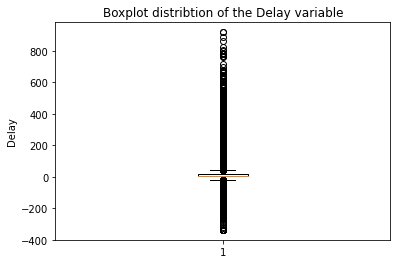

In [ ]:
# Creating plot
plt.boxplot(traffic_df['Delay'])
plt.ylabel('Delay')
plt.title('Boxplot distribtion of the Delay variable')

# show plot
plt.show()

<p>Our correlation matrix indicates that the significant variables are 'ExcessDelay', 'Score', 'Speed', and 'TT'. </p>

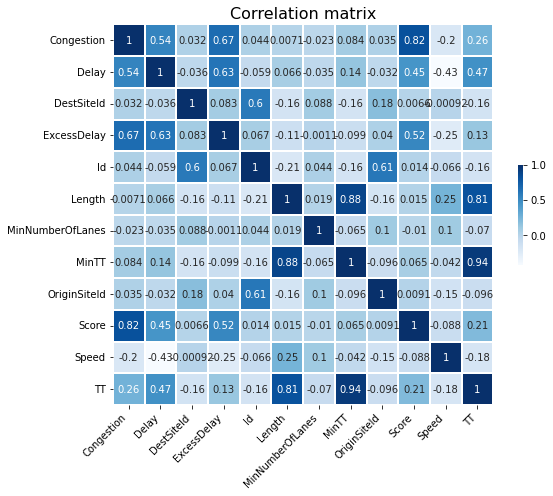

In [ ]:
# Correaltion matrix
corr = traffic_df.select_dtypes(['number']).corr()
plt.figure(figsize=(9,7))
cor_map = sns.heatmap(corr,
                      cmap="Blues",
                      annot=True,
                      square=True,
                      linewidth=1,
                      cbar_kws={'fraction' : 0.01})
cor_map.set_xticklabels(cor_map.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlation matrix', fontsize=16)
plt.show()

<p>Using both an ADF and KPSS test suggests that the delay variable is stationary. This means that over time, the delay of traffic remains the same. As a result of this, regression based models are unlikely to be effective. We can see this visualised in the graphs below.</p>

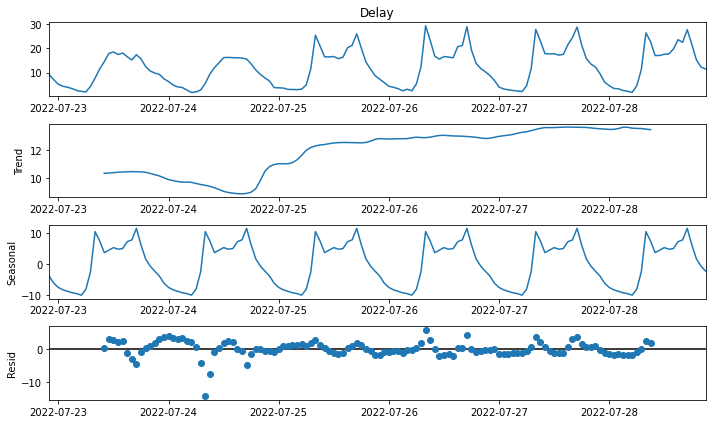

In [ ]:
# data seasonality analysis
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Setting the date as index (time series)
traffic_ts = traffic_df.set_index('IntervalStart')
traffic_ts = traffic_ts['Delay']

# resample delay variable to have an interval of 1 hour
season = traffic_ts.resample('60min').mean()

# select recent values
season = season.loc[(season.index > season.index.max() - pd.DateOffset(days=6)) & (season.index <= season.index.max())]

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
decomposition = sm.tsa.seasonal_decompose(season, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
# ADF Test
result = adfuller(season.values, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
  print ("Reject Ho - Time Series is Stationary (does not have a unit root)")
else:
  print("Failed to Reject Ho - Time Series is Non-atationary (has a unit root)")
# KPSS Test
statistic, p_value, n_lags, critical_values = kpss(season.values, regression='c')
# Format Output
print(f'\nKPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
  print(f'   {key}: {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

ADF Statistic: -7.696948
p-value: 0.000000
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
Failed to Reject Ho - Time Series is Stationary

KPSS Statistic: 0.3493610904352092
p-value: 0.09898228860551328
num lags: 14
Critial Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


<p>When analysing the data, we found that 7.65% were outliers. When grouped by location, this number drops to 1.02%.</p>

In [ ]:
# Percentage of outlier in delay variable
Q1 = traffic_df['Delay'].quantile(0.25)
Q3 = traffic_df['Delay'].quantile(0.75)
IQR = Q3 - Q1

perc_outlier = round(((traffic_df['Delay'] < (Q1 - 1.5 * IQR)) | (traffic_df['Delay'] > (Q3 + 1.5 * IQR))).sum() / len(traffic_df) * 100, 2)

# percentage of oultier grouped into each group
outlier_group = traffic_df[['Delay', 'Name']].groupby("Name").transform(lambda x: (x - x.mean()).abs() > 3*x.std())
perc_outlier_group = round(outlier_group['Delay'].values.sum() / len(traffic_df) * 100, 2)


print("Percentage of outliers in 'Delay' variable: ", perc_outlier, "%")
print("Percentage of outliers in 'Delay' variable grouped by each location: ", perc_outlier_group, "%")

Percentage of outliers in 'Delay' variable:  7.65 %
Percentage of outliers in 'Delay' variable grouped by each location:  1.02 %


<p>After conducting a p-value test, we have found one of the variables to be insignificant (Score) in a linear regression.</p>

In [ ]:
# define predictor and response variables
y = traffic_df['Delay']
x = traffic_df.select_dtypes(['number']).drop(['Delay'], axis=1)

# add constant to predictor variables
x = sm.add_constant(x)

# Train a regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  Delay   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.746e+32
Date:                Fri, 07 Oct 2022   Prob (F-statistic):               0.00
Time:                        04:40:46   Log-Likelihood:             2.7441e+07
No. Observations:             1000000   AIC:                        -5.488e+07
Df Residuals:                  999988   BIC:                        -5.488e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.178e-13   1.73e-15  

## Prepare Data: Use data transforms/scaling/re-shaping and feature selection in order to reduce dimensionality and better expose the structure of the prediction problem to the modeling algorithms. Summarise your data.

<p>Based on the correlation matrix, we have decided to remove the following columns: ‘MinTT’, 'TT', 'Id', 'DestSiteId', 'OriginSiteId' and 'Score'.</p>

In [ ]:
# Remvoe outlier by grouping by each location
traffic_df = traffic_df[outlier_group.Delay == False]

<p>Outliers were removed by grouping delay by location. These outliers could be due to outside factors such as construction, or a car accident, neither of which would be representative of delay in terms of creating a predictive model.</p>

In [ ]:
# In this code, we are dropping the varialbes which are causing colinearity or not needed
traffic_df = traffic_df.drop(['MinTT', 'TT', 'Id', 'DestSiteId', 'OriginSiteId', 'Score'], axis=1)

<p>Next, we transform the 'Trend' variable into a slope of the regression line.</p>

In [ ]:
# Trend varialbe before feature transformation
traffic_df['Trend'].head(3)

0    [85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74]
1    [77, 72, 70, 69, 61, 54, 51, 49, 48, 49, 56, 69]
2    [18, 18, 17, 16, 15, 14, 18, 19, 15, 17, 17, 17]
Name: Trend, dtype: object

In [ ]:
# Transform Trend vriable into a slope of regression line
from scipy.stats import linregress
from numpy import arange

traffic_df['Trend'] = traffic_df['Trend'].apply(lambda x: None if (not x) else linregress(np.arange(0, len(x)).tolist(), x).slope)

traffic_df['Trend'].head(3)

0   -1.000000
1   -1.828671
2   -0.031469
Name: Trend, dtype: float64

<p>We used a standard scaler to re-scale numerical variables. Categorical variables were re-shaped and both categorical and boolean variables were encoded into values of 0 and 1.The data column is split into ‘day’, ‘month’, and ‘year’ values.</p>

In [ ]:
# Normalize a target variable
from sklearn.preprocessing import StandardScaler

# use standard scaler
sc = StandardScaler()

# get numeric data and exclude target variable
num_df = traffic_df.drop('Delay', axis=1).select_dtypes('number')

# update the cols with their normalized values
traffic_df[num_df.columns] = sc.fit_transform(num_df.to_numpy())

# convert string variable to One Hot Encoding
traffic_df = pd.get_dummies(traffic_df)

# get boolean data
bool_df = traffic_df.select_dtypes('bool')

# encode boolean variables into 0 and 1
traffic_df[bool_df.columns] = bool_df.astype('uint8')

# Split date into individual items
traffic_df['Year'] = traffic_df['IntervalStart'].dt.year
traffic_df['Month'] = traffic_df['IntervalStart'].dt.month
traffic_df['Day'] = traffic_df['IntervalStart'].dt.day
traffic_df['Hour'] = traffic_df['IntervalStart'].dt.hour
traffic_df['Minute'] = traffic_df['IntervalStart'].dt.minute

# remove date column
traffic_df = traffic_df.drop('IntervalStart', axis=1)

print(traffic_df.head(3))
print(traffic_df.shape)

<p>At the end of the preprocessing stage, the resulting dataset consists of 587 parameters and 989835 observations.
</p>

## Decide which algorithms will be suited for your project. Explain your reasoning. Select 3-4 algorithms for spot-check and determine the best based on accuracy evaluations.

The resulting dataset following a data preparation stage consists only of discrete and continuous numerical variables. Therefore, each chosen modelling technique needs to be capable of producing a numerical prediction by processing both discrete and continuous numerical parameters. This suggests that the dataset could be used with any regression modelling techniques [3]. However, by skipping the one-hot-encoding process during the data preparation stage, this allows the dataset to be used with any machine learning technologies that are capable of processing multiple data types including numerical and categorical variables and produce numerical prediction.

The findings from analysis on the dataset suggests that, though there are significant fluctuation and time series cycles exist within the dataset, there is no deterministic trend from a long term perspective by considering the stationary characteristic of the dataset [4]. Therefore, we assume that linear models such as linear regression would not be effective in capturing patterns within the dataset and should be avoided. Modelling techniques that are designed to process bivariate data are not recommended due to the high volume of parameters in the dataset. Threofore, we assume that the autoregressive integrated moving average (ARIMA), which is a modelling technique commonly used to forecast on univariate stationary time series data, could be an effective method [5].

It was also found during the earlier analysis that the target variables are very spread out from the mean by its high variance. Therefore, a chosen modelling technique should be robust to outliers. Tree models such as decision trees are relatively insensitive to outliers [6]. We assume that the Random forest model could be effective as it’s the tree based model that is designed for a large dataset.

Conducting a literature review, A. Ata et al utilised a variation of Artificial Neural Network (ANN) to provide a mechanism to predict the traffic congestion [7]. In their model they have used 6 variables including traﬃc speed and traﬃc flow which share similar characteristics with some of the variables in our dataset, and have achieved an accuracy of 97.56% using a time series model and found that a neural network is a plausible approach to find traffic situations. Utilising the findings from their study, we assume that an artificial neural network model is likely to be effective in our study as well.

The list of chosen models is as follows:

- Autoregressive integrated moving average (ARIMA)

- Random Forest

- Artificial neural network (ANN)

## References

[1] Uci.edu. (2019). UCI Machine Learning Repository: Breast Cancer Wisconsin (Diagnostic) Data Set. [online] Available at: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29 [Accessed 7 Oct. 2022].

[2] Leza, C. (2020). So you think you don’t have enough data to do Machine Learning. [online] Analytics Vidhya. Available at: https://medium.com/analytics-vidhya/so-you-think-you-dont-have-enough-data-to-do-machine-learning-3b5c6c512e27 [Accessed 7 Oct. 2022].

[3] Afonja, T. (2018). Kernel Functions. [online] Medium. Available at: https://towardsdatascience.com/kernel-function-6f1d2be6091 [Accessed 7 Oct. 2022].

[4] GeeksforGeeks. (2020). Radial Basis Function Kernel - Machine Learning. [online] Available at: https://www.geeksforgeeks.org/radial-basis-function-kernel-machine-learning/. [Accessed 7 Oct. 2022].

[5] GeeksforGeeks. (2018). Creating linear kernel SVM in Python. [online] Available at: https://www.geeksforgeeks.org/creating-linear-kernel-svm-in-python/ [Accessed 7 Oct. 2022].

[6] Scikit-learn.org. (2019). sklearn.model_selection.GridSearchCV — scikit-learn 0.22 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html. [Accessed 7 Oct. 2022].
